# L4c: K-Nearest Neighbor (KNN) Classification
In this lecture, we'll look at [K-nearest neighbor classification](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) and its kernelized variant, which is an _unsupervised_ approach to solve (binary) classification problems. The key ideas of this lecture are:
* __K-nearest neighbor classification__: Developed by [Fix and Hodges in 1951](https://www.jstor.org/stable/1403797?socuuid=e7bcd649-778e-473f-8b7b-92805b5fab5f) is an _unsupervised_ classification algorithm where an object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its $k$-nearest neighbors, where $k>0$ is typically _small_. Traditionally, distance in a KNN is measured as [the Euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance)
* __Kernelized K-nearest neighbor classification__: is a variation of the standard [KNN algorithm](https://www.jstor.org/stable/1403797?socuuid=e7bcd649-778e-473f-8b7b-92805b5fab5f) that utilizes a kernel function to measure similarity between data points, allowing for more complex non-linear decision boundaries. By using a non-linear kernel, the algorithm can identify complex relationships between data points that are not easily captured by simple Euclidean distance measures, improving classification accuracy on non-linear datasets.

Lecture notes for today can be found: [here!](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-4/L4c/docs/Notes.pdf)

## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem.

In [3]:
include("Include.jl");

Next, let's set some constants we'll need for the data generation logic below. Please look at the comment next to the constant for a description of what it is, permissible values, etc.

In [5]:
number_label_one = 1000; # number of points in cloud 1 (must be ≥ 2)
number_label_two = 1000; # number of points in cloud 2 (must be ≥ 2)
total_number_of_points = (number_label_one + number_label_two);
number_of_features = 3; # features: (x,y,l), where l is a generated label; see below.
c̄₁ = (0.0, 0.0); # center for the cloud: fixed
θ = 60*(π/180); # rotation angle (radians)

Finally, let's set up the color dictionary to visualize the classification datasets. The keys of the `my_color_dictionary::Dict Int64, RGB` dictionary class labels, i.e., $ y\in\{1,-1\}$ while the values are the colors mapped to that label.

In [7]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e"; # color for Label = 1
my_color_dictionary[-1] = colorant"#e36414"; # color for Label = -1

### Data
We'll use [K-nearest neighbor classification](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) to classify datasets, including [the XOR dataset](https://en.wikipedia.org/wiki/Exclusive_or) that we construct. First, we'll generate a master dataset (which may or may not be linearly separable), then split it into (random) `training` and `test` subsets.
* __Training data__: Training datasets are collections of labeled data used to teach machine learning models, allowing these tools to learn patterns and relationships within the data. In our case, we'll use the training data to estimate the classifier parameters $\beta$.
* __Test data__: Test datasets, on the other hand, are separate sets of labeled data used to evaluate the performance of trained models on unseen examples, providing an unbiased assessment of the _model's generalization capabilities_.

Let's start with the master dataset `D::Array{Float64,2}`. This dataset will have two continuous features $\mathbf{x}\in\mathbb{R}^{2}$ and a categorical label $y\in\{-1,1\}$. We'll build a label function $L:\mathbb{R}\times\mathbb{R}\to\{\text{true, false}\}$ (we can change this function around to get different labeling patterns):

In [9]:
# TODO: uncomment this logic for different labeling patterns
# L(x,y) = (y ≥ 0) ? true : false; # rotated half circle (linearly separable)
L(x,y) = (x ≥ 0) && (y ≥ 0) ? true : false; # wedge pattern (not linearly separable)
# L(x,y) = xor(x ≥ 0,y ≥ 0); # XOR pattern alternating pie wedges (not linearly separable)

Generate the master dataset `D`:

In [11]:
D = let
    
    # initialize -
    D = Array{Float64,2}(undef, total_number_of_points, number_of_features);
    s₁ = generatedatacloud(c̄₁, number_of_points = number_label_one, label=0); # generate label 1 data
    s₂ = generatedatacloud(c̄₁, number_of_points = number_label_two, label=0); # generate label 2 data

    # mix s₁, s₂ together (randomly)
    tmp = vcat(s₁,s₂)
    random_perm_index_vector = randperm(total_number_of_points);
    for i ∈ eachindex(random_perm_index_vector)
        k = random_perm_index_vector[i]; # get the from col -
        for j ∈ 1:number_of_features
            D[i,j] = tmp[k,j];
        end
    end

    # compute the label by taking the XOR, OR, AND, etc functions
    for i ∈ 1:total_number_of_points
        flag = L(D[i,1],D[i,2]);
        if (flag == true)
            D[i,3] = 1
        else
            D[i,3] = -1
        end
    end

    # finally, let's rotate the data a bit (counter-clockwise)
    R = [
        cos(θ) -sin(θ) ;
        sin(θ) cos(θ) ;
    ];

    # keep the label, but apply the rotation the (x,y) data
    D̂ = copy(D);
    for i ∈ 1:total_number_of_points
        x̂ = R*D[i,1:2];
        D̂[i,1] = x̂[1];
        D̂[i,2] = x̂[2];
    end
    
    D̂ # return the data
end;

#### Visualize dataset `D`
`Unhide` the code block below to see how we plotted the dataset `D` which contains two continuous features and a label. The color indicates the label.
* __Summary__: We will get a different pattern of $\pm{1}$ labels depending on the labeling function logic $L(x_{1},x_{2})$ we used. The dark blue dots represent label `1`, while the orange data represents label `1`. Our 
classifier should be able to learn the mapping between the features and the labels for linearly separable datasets.

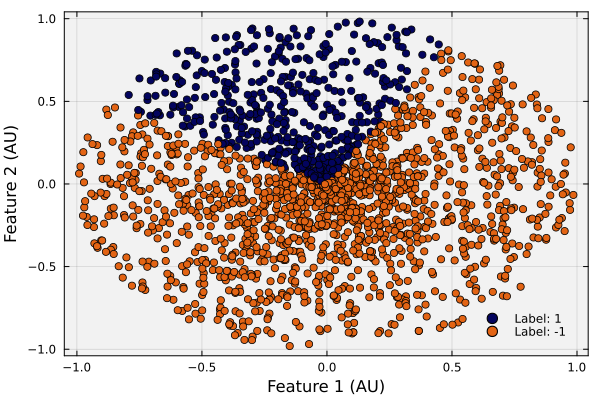

In [13]:
let

    dataset = D; # what dataset am I looking at?
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot

    # plot label = 1
    testlabel = 1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot label = -1
    testlabel = -1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot all points
    for i ∈ 1:total_number_of_points
        label = dataset[i,3]; # label
        c = my_color_dictionary[label]
        scatter!([dataset[i, 1]], [dataset[i, 2]], label="", mec=:navy, c=c)
    end
    
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end

Next, let's split that dataset `D` into `training` and `test` subsets. We do this randomly, where the `number_of_training_examples::Int64` variable specifies the number of training points. The `training::Array{Float64,2}` data will be used to estimate the model parameters, and `test::Array{Float64,2}` will be used for model testing.

In [15]:
training, test = let

    number_of_training_examples = 1200; # we make this number of
    number_of_examples = total_number_of_points;
    full_index_set = range(1,stop=number_of_examples,step=1) |> collect |> Set;
    
    # build index sets for training and testing
    training_index_set = Set{Int64}();
    should_stop_loop = false;
    while (should_stop_loop == false)
        i = rand(1:number_of_examples);
        push!(training_index_set,i);

        if (length(training_index_set) == number_of_training_examples)
            should_stop_loop = true;
        end
    end
    test_index_set = setdiff(full_index_set,training_index_set);

    # build the test and train datasets -
    training = D[training_index_set |> collect,:];
    test = D[test_index_set |> collect,:];

    # return
    training, test
end;

## K-Nearest Neighbor Classification
K-nearest neighbor (KNN) classification is a simple yet powerful machine learning algorithm for classification and regression tasks. The algorithm finds the K closest data points to a new instance in the feature space and then classifies the new instance based on the majority class among these neighbors.

* __Key assumption__: The key assumption of a K-nearest neighbor classifier is that _similar_ inputs have _similar_ labels (in classification tasks) or _similar_ outputs for K-nearest neighbor regression tasks. However, the wiggly aspect of this assumption is what we mean by _similar_.

__Algorithm__
* __Initialization__. You provide the dataset $\mathcal{D} = \{(\mathbf{x}_{i},y_{i}) \mid i = 1,2,\dots,n\}$, where the vectors $\mathbf{x}_i \in \mathbb{R}^{m}$ are $m$-dimensional feature vectors ($m\ll{n}$) and the target variables are discrete labels $y_i \in \left\{-1,1\right\}$. 
* __Inference__: The distances (similarity) between a test feature vector $\mathbf{z}$ and _all training instances_ is computed; call this set $\mathcal{S}$. Set $\mathcal{S}$ is sorted from highest to lowest similarity. Then, the probability of a particular label is estimated from the labels of the top-K elements of the sorted neighbor set.

Fill me in

In [17]:
ŷ,y = let

    D = training;
    number_of_training_examples = size(training,1);
    X = D[:,1:end-1]; # notice no extra 1
    y = D[:,end]; # label
    ŷ = zeros(number_of_training_examples);

    
    # build a model -
    model = build(MyKNNClassificationModel, (
        K = 100,
        d = (x,y) -> norm(x-y)^2 # squared E. distance
    ));

    # process each vector in the training, can we get the correct label
    # for i ∈ 1:number_of_training_examples
    #     z = X[i,:]; # get feature vector
    #     ŷ[i] = classify(z,X,y,model)
    # end
    i = 2;
    z = X[i,:]; # get feature vector
    tmp = classify(z,X,y,model)
    
    tmp,y
end;

(invcounts, counts, class) = (Dict(100 => -1), Dict(-1 => 100), 1)


In [18]:
ŷ

1

In [19]:
y[1]

-1.0